<a href="https://www.kaggle.com/code/seandokko/baseline-initial-baseline-for-dirty-water?scriptVersionId=117157630" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import setup_comp, iskaggle, push_notebook
import pandas as pd
import numpy as np
import torch
from fastai.tabular.all import *

In [2]:
comp = 'ml-olympiad-waterqualityprediction'

path = setup_comp(comp)
path.ls()

(#3) [Path('../input/ml-olympiad-waterqualityprediction/sample_submission.csv'),Path('../input/ml-olympiad-waterqualityprediction/train.csv'),Path('../input/ml-olympiad-waterqualityprediction/test.csv')]

In [3]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [4]:
train_df.head()

,id,categoryA,categoryB,categoryC,categoryD,categoryE,categoryF,featureA,featureB,featureC,...,compositionC,compositionD,compositionE,compositionF,compositionG,compositionH,compositionI,compositionJ,unit,result
0,a563699ca2a601c6ac64aa29986a00a90fb42b48741695b0526a286d504d17ca,catA_1,catB_0,catC_718,catD_0,catE_0,catF_0,75808.375,4.457840,0.005718,...,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0,unit_6,0.000458
1,91ab3eb3bcf6c8c1c5fe2da9ba671aa5a48c7369d9a50f32e1ddd735472b4b3c,catA_1,catB_0,catC_1309,catD_0,catE_0,catF_0,75808.375,4.457840,0.005718,...,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0,unit_6,0.000335
2,7128c51c554735d6c81862684ad6005ae12d2edbcd464487a7217fc72c03ba22,catA_15,catB_0,catC_1309,catD_0,catE_0,catF_0,75808.375,4.457840,0.005718,...,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0,unit_4,0.054072
3,c8144b52e4f63014de0a0d8e1c629bf0b05cb2696cfc23291b4f48e6491c4cb5,catA_0,catB_0,catC_935,catD_0,catE_0,catF_0,75808.375,4.457840,0.005718,...,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0,unit_5,0.061143
4,88d15a5b2df6692f23d105ff1ae82ae026be00c9271eef33e0aea97fd2110cb6,catA_22,catB_0,catC_1325,catD_0,catE_2,catF_0,-40055.250,4.363288,0.729194,...,14.0,0.0,49.0,3.0,2.0,9.0,16.84,15.0,unit_15,0.015439


In [5]:
category_columns = ['category' + c for c in ['A', 'B', 'C', 'D', 'E', 'F']] + ['unit']
feature_columns = ['feature' + c for c in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']]
composition_columns = ['composition' + c for c in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']]

train_df[category_columns + feature_columns + composition_columns].head()

,categoryA,categoryB,categoryC,categoryD,categoryE,categoryF,unit,featureA,featureB,featureC,...,compositionA,compositionB,compositionC,compositionD,compositionE,compositionF,compositionG,compositionH,compositionI,compositionJ
0,catA_1,catB_0,catC_718,catD_0,catE_0,catF_0,unit_6,75808.375,4.457840,0.005718,...,0.0,10.0,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0
1,catA_1,catB_0,catC_1309,catD_0,catE_0,catF_0,unit_6,75808.375,4.457840,0.005718,...,0.0,10.0,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0
2,catA_15,catB_0,catC_1309,catD_0,catE_0,catF_0,unit_4,75808.375,4.457840,0.005718,...,0.0,10.0,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0
3,catA_0,catB_0,catC_935,catD_0,catE_0,catF_0,unit_5,75808.375,4.457840,0.005718,...,0.0,10.0,26.0,0.0,32.0,3.0,0.0,9.0,22.26,20.0
4,catA_22,catB_0,catC_1325,catD_0,catE_2,catF_0,unit_15,-40055.250,4.363288,0.729194,...,0.0,8.0,14.0,0.0,49.0,3.0,2.0,9.0,16.84,15.0


In [6]:
dls = TabularDataLoaders.from_df(train_df, procs=[Categorify, FillMissing, Normalize], cat_names=category_columns, cont_names=feature_columns+composition_columns, y_names='result')

In [7]:
def rmsle(pred, actual):
  pred = torch.log(pred + 1)
  actual = torch.log(actual + 1)
  return torch.sqrt(torch.mean(pred - actual) ** 2)

predicted = torch.tensor([1, 2, 3, 4, 5])
actual = torch.tensor([1.1, 2.2, 3.3, 4.4, 5.5])
print("RMSLE: ", rmsle(predicted, actual))

RMSLE:  tensor(0.0685)


In [8]:
dls.loss_func

FlattenedLoss of MSELoss()

In [9]:
learner = tabular_learner(dls, metrics=rmsle)

SuggestedLRs(valley=0.0005754399462603033)

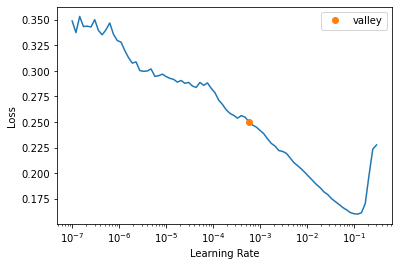

In [10]:
learner.lr_find()

In [11]:
learner.fit(10, lr=10e-3)

epoch,train_loss,valid_loss,rmsle,time
0,0.018299,0.017542,0.010314,00:02
1,0.010720,0.009514,0.013315,00:02
2,0.008622,0.009158,0.013446,00:02
3,0.006997,0.008930,0.009557,00:02
4,0.006406,0.009940,0.012581,00:02
5,0.004722,0.008109,0.006760,00:02
6,0.004034,0.007511,0.013287,00:02
7,0.003585,0.007439,0.008344,00:02
8,0.003568,0.007679,0.017512,00:02
9,0.003130,0.007273,0.009064,00:02


In [12]:
dl = dls.test_dl(test_df)

In [13]:
preds, _ = learner.get_preds(dl=dl)
sub = test_df.copy()
sub['result'] = preds

sub[['id', 'result']].to_csv('subm.csv', index=False)

In [14]:
if not iskaggle:
  from kaggle import api
  api.competition_submit_cli('subm.csv', 'initial baseline', comp)

In [15]:
if not iskaggle:
    push_notebook('seandokko', 'initial-baseline-for-dirty-water',
                  title='Initial Baseline for Dirty Water',
                  file='baseline.ipynb',
                  competition=comp, private=False, gpu=True)